In [100]:
"""
 Peak alignment between mass spectrum in the whole dataset 
"""
import os
import pandas as pd
import pickle
import biotype.similarity as sim

In [101]:
DATA_DIR_PATH = "datasets/export"
PEAK_DIR_PATH = "extracted_peaks"
files =  os.listdir(DATA_DIR_PATH)
files = [fn  for fn in files if fn.endswith(".txt")]
files = sorted(files)
files[:5]

['L100_0_G7_1.txt',
 'L100_0_G8_1.txt',
 'L101_0_A1_1.txt',
 'L101_0_A2_1.txt',
 'L102_0_A3_1.txt']

In [102]:
n = len(files)
all_peaks = [] # list of tuples (m/z, intensity, dataset_id) ordered by m/z value
for i in range(n):
    df = None
    df = pd.read_table(f"{DATA_DIR_PATH}/{files[i]}",sep=" ", header=None,names=['m/z', 'intensity']) 
    x, y = df['m/z'].to_numpy(), df['intensity'].to_numpy()

    pickle_file = files[i][:-4] # trim '.txt'
    with open(f'{PEAK_DIR_PATH}/{pickle_file}_peaks.pkl', 'rb') as peak_file:
        peaks = pickle.load(peak_file)
        # peaks_extracted +=  [(x[peaks], y[peaks])] 
        for p in peaks:
            all_peaks += [(x[p],y[p], i)]

all_peaks = sorted(all_peaks, key=lambda x: x[0])
all_mz = [mz for mz,pk,ms in all_peaks]
all_mz[:5]

[1000.748, 1000.748, 1000.871, 1000.871, 1000.948]

In [103]:
print(f"min={all_mz[0]}, max={all_mz[-1]}, N={len(all_mz)}")
mz_min, mz_max = all_mz[0], all_mz[-1]

min=1000.748, max=20073.668, N=20923


In [104]:
import pandas as pd
df = pd.DataFrame(all_peaks, columns=['mz', 'intensity', 'dataset_id'])
df.head()

,mz,intensity,dataset_id
0,1000.748,5652,42
1,1000.748,2899,90
2,1000.871,7600,93
3,1000.871,6380,95
4,1000.948,2654,100


In [105]:
df.tail()

,mz,intensity,dataset_id
20918,20070.254,284,47
20919,20070.681,481,7
20920,20071.480,1,0
20921,20071.961,264,61
20922,20073.668,246,82


<AxesSubplot:>

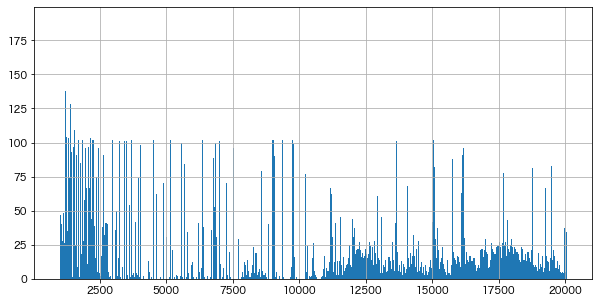

In [108]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5     
df['mz'].hist(bins=1000)

In [109]:
import itertools
""" Partition to groups not exceeding delta --> TO BE DELETED
"""
def grouper(iterable, delta=5):
    low = None
    group = []
    for item in iterable:
        if low is None or item - low <= delta:
            group.append(item)
            if low is None:
                low = item
        else:
            yield group
            group = [item]
            low = item
    if group:
        yield group

numbers = [123, 124, 128, 160, 167, 213, 215, 230, 245, 255, 257, 400, 401, 402, 430]dict(enumerate(grouper(numbers, 15), 1))

{1: [123, 124, 128],
 2: [160, 167],
 3: [213, 215],
 4: [230, 245],
 5: [255, 257],
 6: [400, 401, 402],
 7: [430]}

# Algorithms
- algorithm 1 (segment): reccurisively divide data whenever gap > delta, w.r.t. step=1,2,...
- algorithm 2 (sequent_join): reccurisively join leftmost neighbors when span < epsilon
- algorithm 3 (nearest_join): reccurisively join nearest neighbors when span < epsilon 
# @params
- `data`: data to process
- `delta`: reject threshold, data with a gap wider than `delta` will be divided
- `epsilon`: accept threshold, neighbors close enough (`epsilon`) will be joined

In [115]:
def pairwise(iterable):
    """ generate pair of consequent items   
      [s0,s1,s2,s3] -> [(s0, s1), (s1, s2), (s2, s3)]
    """
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a,b)

print (list(pairwise([1,2,3,5,6])))

[(1, 2), (2, 3), (3, 5), (5, 6)]


In [116]:
def segment(data, delta=3):
    """ algorithm 1 (segment): reccurisively divide data whenever gap > delta, w.r.t. step=1,2,3,...
    """
    return exec_segment(data, [-1, len(data)-1], delta, 1)
        
def exec_segment(data, bins, delta, step):
    new_bins = bins[:]
    done = True
    for s, t in pairwise(bins):
        for i in range(s+1, t, step):
            j = i + step
            if j<=t and data[j] - data[i] > delta:
                new_bins += [j-1]
                done = False
                    
    bins = sorted(list(set(new_bins)))
    
    if done:
        return bins
    else:
        return exec_segment(data, bins, delta, step+1)
    

In [117]:
delta = 3
bins = segment(all_mz, delta)
print(bins[:10])
print(bins[-10:])

[-1, 32, 106, 120, 164, 167, 219, 220, 321, 344]
[20877, 20881, 20883, 20887, 20888, 20891, 20894, 20898, 20916, 20922]


In [118]:
for i, j in pairwise(bins):
    d = all_mz[j]-all_mz[i+1]
    print(f"[{all_mz[i+1]:.3f}, {all_mz[j]:.3f}]:{j-i:3d} {d:.3f} {'*' if d>delta else 'y'}")

[1000.748, 1002.126]: 33 1.378 y
[1007.214, 1009.410]: 74 2.196 y
[1016.519, 1017.667]: 14 1.148 y
[1023.418, 1025.339]: 44 1.921 y
[1031.650, 1033.425]:  3 1.775 y
[1044.123, 1046.584]: 52 2.461 y
[1049.304, 1049.304]:  1 0.000 y
[1053.259, 1055.729]:101 2.470 y
[1061.848, 1064.815]: 23 2.967 y
[1064.883, 1066.382]: 12 1.499 y
[1073.961, 1076.301]:  4 2.340 y
[1076.990, 1078.074]:  6 1.084 y
[1085.871, 1088.245]: 36 2.374 y
[1088.938, 1088.938]:  1 0.000 y
[1092.803, 1092.803]:  1 0.000 y
[1095.958, 1098.471]: 26 2.513 y
[1114.818, 1117.741]: 35 2.923 y
[1118.544, 1118.544]:  1 0.000 y
[1122.461, 1125.265]:  3 2.804 y
[1125.970, 1128.904]: 32 2.934 y
[1129.005, 1130.921]: 32 1.916 y
[1146.305, 1149.157]: 17 2.852 y
[1149.463, 1149.971]:  3 0.508 y
[1151.193, 1151.193]:  1 0.000 y
[1151.396, 1153.332]: 28 1.936 y
[1158.228, 1158.228]:  2 0.000 y
[1164.875, 1168.463]:102 3.588 *
[1173.905, 1176.891]:  3 2.986 y
[1178.333, 1180.391]: 17 2.058 y
[1187.205, 1188.756]:  6 1.551 y
[1192.173,

[15748.903, 15751.926]:  4 3.023 *
[15751.926, 15753.815]:  8 1.889 y
[15756.083, 15758.728]:  9 2.645 y
[15759.106, 15759.106]:  1 0.000 y
[15761.677, 15761.677]:  1 0.000 y
[15762.718, 15762.718]:  1 0.000 y
[15769.359, 15772.338]:  4 2.979 y
[15773.473, 15776.120]: 23 2.647 y
[15776.498, 15781.036]: 60 4.538 *
[15781.793, 15781.793]:  1 0.000 y
[15782.857, 15784.371]:  4 1.514 y
[15784.441, 15784.441]:  1 0.000 y
[15797.305, 15797.305]:  1 0.000 y
[15804.117, 15806.767]:  2 2.650 y
[15807.524, 15810.174]:  3 2.650 y
[15810.553, 15812.824]:  7 2.271 y
[15813.582, 15815.475]:  3 1.893 y
[15816.232, 15817.368]:  2 1.136 y
[15817.368, 15820.337]:  3 2.969 y
[15825.321, 15825.321]:  1 0.000 y
[15828.352, 15830.625]:  2 2.273 y
[15836.308, 15838.146]:  3 1.838 y
[15839.339, 15839.339]:  1 0.000 y
[15842.750, 15842.750]:  2 0.000 y
[15846.540, 15848.056]:  3 1.516 y
[15849.951, 15853.039]:  3 3.088 *
[15854.500, 15857.154]:  4 2.654 y
[15857.861, 15860.567]:  7 2.706 y
[15862.842, 15862.84

In [190]:
def sequent_join(data, delta=5, epsilon=1):
    """ algorithm 2 (sequent_join): reccurisively join leftmost neighbors when span < epsilon
    """
    bins = [[v] for v in data]
    
    for d in reversed(range(11)):
        new_bins = []
        i, e = 0, epsilon/2**d
        while i < len(bins):
            if i == len(bins)-1:
                new_bins += [bins[i]]
                break

            a, b = bins[i], bins[i+1]
            if max(b) - min(a) < e: # |span{a, b}|< e
                new_bins += [a+b]
                i += 2
            else:
                new_bins += [a]
                i += 1
            
        bins = new_bins[:]
        
    return bins


In [198]:
delta, epsilon =5, 2
bins = sequent_join(all_mz, delta, epsilon) 
for x in bins:
    print(f"{len(x): 3d} [{min(x):.3f},{max(x):.3f}] d={max(x)-min(x):.3f} {'y' if max(x)-min(x)<=epsilon else '**'}")

 33 [1000.748,1002.126] d=1.378 y
 73 [1007.214,1008.880] d=1.666 y
  1 [1009.410,1009.410] d=0.000 y
 14 [1016.519,1017.667] d=1.148 y
 42 [1023.418,1024.858] d=1.440 y
  2 [1025.219,1025.339] d=0.120 y
  3 [1031.650,1033.425] d=1.775 y
 48 [1044.123,1045.614] d=1.491 y
  4 [1045.905,1046.584] d=0.679 y
  1 [1049.304,1049.304] d=0.000 y
 82 [1053.259,1054.965] d=1.706 y
 19 [1055.046,1055.729] d=0.683 y
  9 [1061.848,1063.738] d=1.890 y
 25 [1063.934,1065.696] d=1.762 y
  1 [1066.382,1066.382] d=0.000 y
  2 [1073.961,1074.825] d=0.864 y
  7 [1075.907,1077.680] d=1.773 y
  1 [1078.074,1078.074] d=0.000 y
 30 [1085.871,1087.651] d=1.780 y
  7 [1088.013,1088.938] d=0.925 y
  1 [1092.803,1092.803] d=0.000 y
 22 [1095.958,1097.867] d=1.909 y
  4 [1098.166,1098.471] d=0.305 y
 26 [1114.818,1116.169] d=1.351 y
  8 [1116.337,1116.939] d=0.602 y
  2 [1117.741,1118.544] d=0.803 y
  1 [1122.461,1122.461] d=0.000 y
  3 [1125.164,1125.970] d=0.806 y
 23 [1126.373,1128.299] d=1.926 y
 34 [1128.400,

  3 [14437.669,14438.755] d=1.086 y
  2 [14440.202,14440.925] d=0.723 y
  2 [14443.096,14444.181] d=1.085 y
  3 [14446.714,14447.075] d=0.361 y
  4 [14454.281,14456.092] d=1.811 y
  1 [14464.448,14464.448] d=0.000 y
  2 [14467.885,14468.069] d=0.184 y
  1 [14472.052,14472.052] d=0.000 y
  1 [14481.832,14481.832] d=0.000 y
  2 [14485.092,14485.817] d=0.725 y
  2 [14491.977,14493.426] d=1.449 y
  3 [14494.876,14495.601] d=0.725 y
  7 [14496.688,14498.138] d=1.450 y
  6 [14498.863,14500.675] d=1.812 y
  7 [14501.763,14503.576] d=1.813 y
  5 [14503.938,14505.388] d=1.450 y
  5 [14506.113,14507.926] d=1.813 y
  3 [14509.377,14510.827] d=1.450 y
  1 [14513.003,14513.003] d=0.000 y
  1 [14515.904,14515.904] d=0.000 y
  1 [14526.335,14526.335] d=0.000 y
  1 [14528.952,14528.952] d=0.000 y
  3 [14530.778,14532.593] d=1.815 y
  1 [14534.396,14534.396] d=0.000 y
  1 [14546.749,14546.749] d=0.000 y
  1 [14553.279,14553.279] d=0.000 y
  3 [14555.465,14556.191] d=0.726 y
  1 [14558.733,14558.733] d=

  3 [19377.259,19377.678] d=0.419 y
  2 [19381.033,19381.447] d=0.414 y
  2 [19384.808,19386.627] d=1.819 y
  2 [19390.694,19391.939] d=1.245 y
  3 [19394.036,19395.714] d=1.678 y
  2 [19399.071,19399.634] d=0.563 y
  3 [19400.329,19401.169] d=0.840 y
  3 [19401.588,19402.427] d=0.839 y
  1 [19405.784,19405.784] d=0.000 y
  2 [19407.883,19409.142] d=1.259 y
  1 [19411.240,19411.240] d=0.000 y
  3 [19413.339,19414.618] d=1.279 y
  1 [19428.032,19428.032] d=0.000 y
  4 [19431.139,19432.819] d=1.680 y
  2 [19441.051,19441.499] d=0.448 y
  1 [19443.151,19443.151] d=0.000 y
  2 [19445.252,19446.932] d=1.680 y
  1 [19449.873,19449.873] d=0.000 y
  2 [19452.393,19452.814] d=0.421 y
  3 [19454.944,19456.595] d=1.651 y
  2 [19457.436,19457.611] d=0.175 y
  4 [19460.377,19461.218] d=0.841 y
  2 [19463.319,19464.734] d=1.415 y
  3 [19466.261,19467.102] d=0.841 y
  2 [19467.942,19468.363] d=0.421 y
  2 [19470.918,19471.350] d=0.432 y
  1 [19472.987,19472.987] d=0.000 y
  2 [19478.487,19479.749] d=

In [ ]:
def nearest_join(data, delta, epsilon): 
    """algorithm 3 (nearest_join): 
    reccurisively join nearest neighbors when span < epsilon 
    """
    pass
